In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('merch_data.xlsx')
data.head()

,门店id,医院编码,门店名称,宠主id,产品编码,产品名称,一级目录,二级目录,三级目录,产品品牌,产品数量,销售金额,revenue,支付日期,类别
0,1023,CX0078,宠颐生上海金丰维康,10299111,S000APU7XP,拜恩-GARTER羊奶粉300g-集,商品,主粮类,奶粉类,暂无,1,120.0,120.0,2020-05-26,其他主粮
1,1023,CX0078,宠颐生上海金丰维康,10299111,S0402XX1143,宠儿香猫用赖氨酸口服补充粉剂2g（袋）,商品,保健品,综合护理类,宠儿香,1,6.0,6.0,2020-05-26,NaN
2,1023,CX0078,宠颐生上海金丰维康,10299111,S0402XX1152,杜力德宠物康健灵1.5g（袋）-集,商品,保健品,综合护理类,杜力德,5,75.0,375.0,2020-06-04,NaN
3,1023,CX0078,宠颐生上海金丰维康,10369311,S0406XX1037,汉维宠舒宝犬猫胃肠条理止泻糖浆30ml-集,商品,保健品,消化系统护理类,汉维,1,130.0,130.0,2020-05-01,NaN
4,1023,CX0078,宠颐生上海金丰维康,10372496,S000LX6C3V,它时代猫用化毛膏120g,商品,营养膏,XXXXXX,暂无,1,150.0,150.0,2020-05-24,NaN


In [14]:
# add a new column
week_num = pd.to_datetime(data['支付日期'])
data['week_num'] = week_num.dt.week

In [15]:
a = data.groupby('产品名称').sum()['产品数量']
# best selling sku
a[a == a.max()].index

Index(['杜力德宠物康健灵1.5g（袋）-集'], dtype='object', name='产品名称')

In [16]:
# a = data.groupby('支付日期').sum()['产品数量'].index.to_series()
# a = pd.to_datetime(a)
# dayofweek = list(a.dt.dayofweek)
# weekdays = {}
# weekends = {}
# for i in range(len(data.groupby('支付日期').sum()['产品数量'].index)):
#     if dayofweek[i]!=5 and dayofweek[i]!=6:
#         weekdays[a[i]] = data.groupby('支付日期').sum()['产品数量'][i]
#     else:
#         weekends[a[i]] = data.groupby('支付日期').sum()['产品数量'][i]

# DNN

First we need to get the weekly sales(a series of sales) of 猫主粮 for each store 

In [17]:
# get weekly sales of '猫主粮' for each store 
stores = data['门店名称'].unique()
sales = {}
for s in stores:
    tmp = data[data['门店名称']==s]
    sale = tmp[tmp['类别']=='猫主粮'].groupby('week_num').sum()['产品数量'] # weekly sale (series)
    if len(sale)!=0:
        sales[s] = sale

some stores strangely have a lot of missing data, here I fill in middle weeks that have no sales with 0

In [18]:
missing_weeks = []
all_stores_with_with_sale = list(sales.keys()) # a list of stores that have sales (included in sales dictionary)
for i in range(len(sales)):
    current_store_sale = sales[all_stores_with_with_sale[i]]
    all_week = list(range(current_store_sale.index[0],current_store_sale.index[-1]+1))
    missing_dates = list(set(all_week) - set(list(current_store_sale.index)))
    for j in missing_dates:
        # if a week has no sale, use 0 as a placeholder for continuity of data
        current_store_sale.loc[j]=0
        missing_weeks.append(i)
    current_store_sale.sort_index(inplace=True)

now sales is a dictionary with store names as keys, and their corresponding weekly sales series as values

In [28]:
values = [] # a list of lists with stores' sales
for i in range(len(list(sales.values()))):
    values.append(list(list(sales.values())[i]))
seq = [] # get a big sequence with all the sales merged together
for i in range(len(values)):
    for j in range(len(values[i])):
        seq.append(values[i][j]) 
# convert to a dataframe
dict = {}
for i in range(len(seq)):
    dict[i]=seq[i]
df = pd.DataFrame.from_dict(dict,orient='index')
df.columns = ['sales']
df.head(15)

,sales
0,8
1,16
2,5
3,16
4,10
5,24
6,20
7,17
8,18
9,31


## method 1

In [30]:
data = pd.DataFrame(df['sales'].copy())
data.head()
# add the lags of the target variable
for i in range(1, 5):
    data['lag_{}'.format(i)] = data['sales'].shift(i)
data = data.dropna()
# add window statistics e.g. rolling mean 
lag_cols = [col for col in data.columns if 'lag' in col] # extract lag columns
data['rolling_mean'] = data[lag_cols].mean(axis=1)
# extract out the features and labels into separate variables X and y (for machine learning input and output variables)
y = data['sales'].values # target variable array 
# data = data.drop('sales', axis=1)
X = data.values # input variable in an array 

In [31]:
data.head(10)

,sales,lag_1,lag_2,lag_3,lag_4,rolling_mean
4,10,16.0,5.0,16.0,8.0,11.25
5,24,10.0,16.0,5.0,16.0,11.75
6,20,24.0,10.0,16.0,5.0,13.75
7,17,20.0,24.0,10.0,16.0,17.50
8,18,17.0,20.0,24.0,10.0,17.75
9,31,18.0,17.0,20.0,24.0,19.75
10,20,31.0,18.0,17.0,20.0,21.50
11,9,20.0,31.0,18.0,17.0,21.50
12,32,9.0,20.0,31.0,18.0,19.50
13,17,32.0,9.0,20.0,31.0,23.00


In [21]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

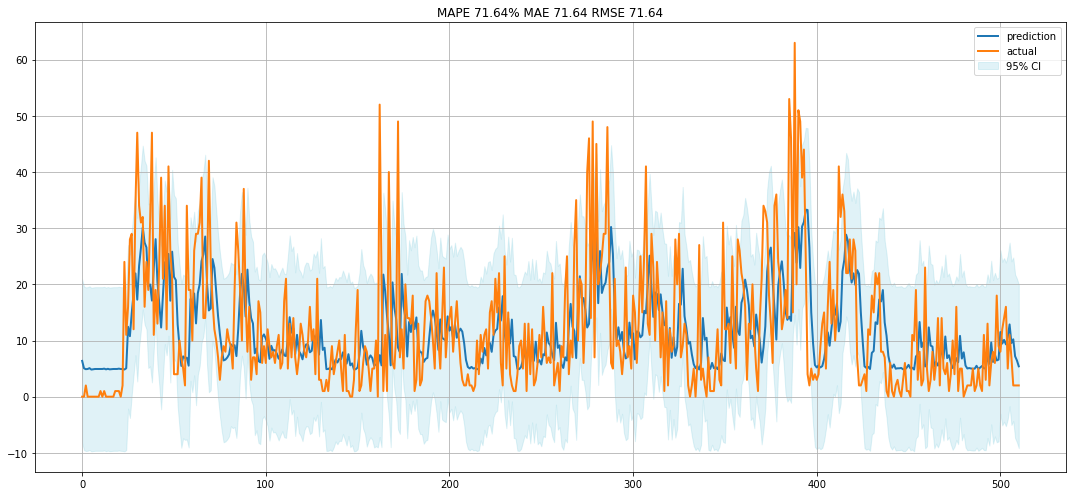

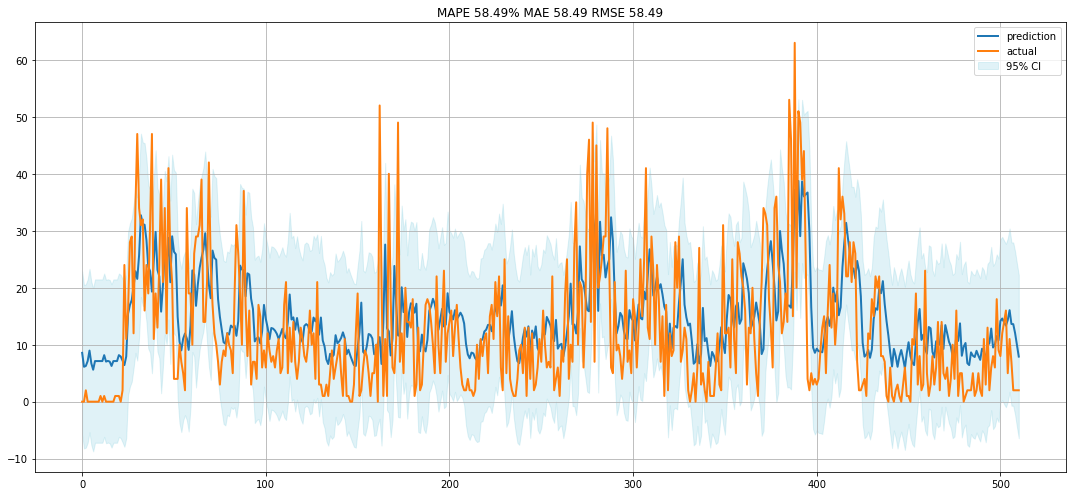

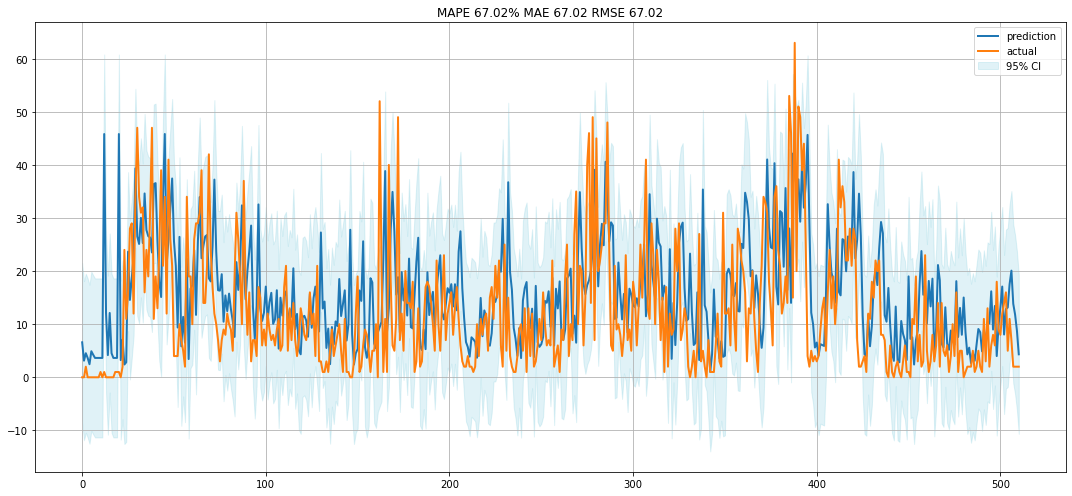

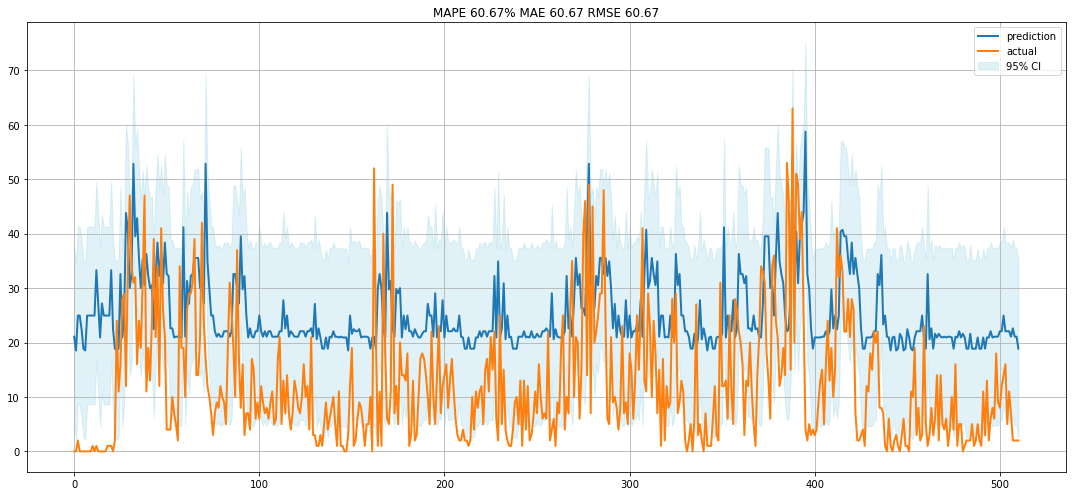

In [22]:
def timeseries_train_test_split(X, y, test_size):
    """Perform train-test split with respect to time series structure(not randomized)."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def plot_model_results(X, y, model, test_size=0.3, plot_intervals=False, plot_anomalies=False):
    """
    - Plots modelled vs original values.
    - Prediction intervals (95% confidence interval).
    - Anomalies (points that resides outside the confidence interval).
    """

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

    model = model
    
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))

    x = range(prediction.size)
    plt.plot(x, prediction, label='prediction', linewidth=2.0)
    plt.plot(x, y_test, label='actual', linewidth=2.0)
    if plot_intervals:
        timeseries_cv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                             cv=timeseries_cv, scoring='neg_mean_absolute_error')
        mae = -1 * cv.mean()
        deviation = cv.std()

        # 95% confidence interval
        scale = 1.96
        margin_error = mae + scale * deviation
        lower = prediction - margin_error
        upper = prediction + margin_error

        fill_alpha = 0.2
        fill_color = '#66C2D7'
        plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')      

        if plot_anomalies:
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    MAPE = mean_absolute_percentage_error(prediction, y_test)
    MAE = mean_absolute_error(y_test,prediction)
    RMSE = np.sqrt(mean_squared_error(y_test,prediction))
    plt.title('MAPE {0:.2f}% MAE {0:.2f} RMSE {0:.2f}'.format(MAPE,MAE,RMSE))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    
    return model
models = [SVR(), MLPRegressor(), RandomForestRegressor(max_depth=50), AdaBoostRegressor(n_estimators=50)]
for i in models:
    plot_model_results(X, y, i, plot_intervals=True)

## method 2

In [79]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
# choose a step size of 4 (a month)
n_steps = 4
n_features = 1

In [80]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [94]:
X, y = split_sequence(values[0], n_steps) 
for i in range(1,len(values)-2): # save two stores' data for testing
    # split into samples
    tmp_X, tmp_y = split_sequence(values[i], n_steps)
    if len(tmp_X)!=0:
        # stack shaped data on th-e previous
        X = np.vstack((X,tmp_X))
        y = np.append(y,tmp_y)

In [96]:
split = int(np.round(0.7*X.shape[0]))
X_train = X[:split]
y_train = y[:split]
X_val = X[split:]
y_val = y[split:]

In [99]:
model_dnn = Sequential()
model_dnn.add(Dense(100, activation='relu', input_dim=n_steps))
model_dnn.add(Dense(1))
model_dnn.compile(optimizer='adam', loss='mse')
# fit model
model_dnn.fit(X_train, y_train, epochs=500, verbose=0)

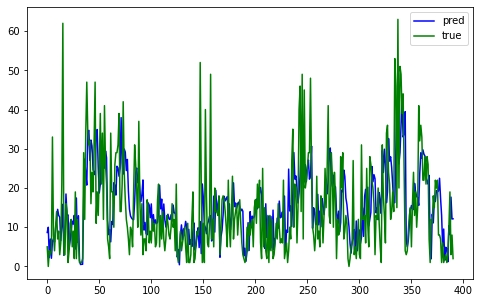

In [135]:
plt.figure(figsize=(8,5))
plt.plot(range(len(y_val)),model_dnn.predict(X_val),c='blue',label='pred')
plt.plot(range(len(y_val)),y_val,c='green',label='true')
plt.legend()

In [130]:
# prepare test data (two remaining stores)
X_test_1, y_test_1 = split_sequence(values[-1][:-1], n_steps)
X_test_2, y_test_2 = split_sequence(values[-2][:-1],n_steps)

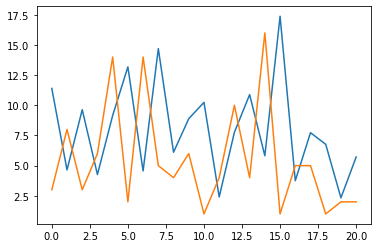

In [134]:
# use trained model to get prediction on test data
plt.plot(range(len(y_test_2)),model_dnn.predict(X_test_2))
plt.plot(range(len(y_test_2)),y_test_2)
# plt.plot(range(len(y_test_1)),model_dnn.predict(X_test_1))
# plt.plot(range(len(y_test_1)),y_test_1)